In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars, get_ap_ar_for_train_val
from utils.save import get_data_from_metric_logger
from utils.coco_utils import get_cocos

from models.setup import ModelSetup
from models.build import create_model_from_setup
from models.train import TrainingInfo
from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders

from IPython.display import clear_output
from utils.eval import get_ar_ap
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.init import reproducibility, clean_memory_get_device
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
from  datetime import datetime
import torch.optim as optim

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
### [TODO] ###

# [ ] -



In [3]:
device = clean_memory_get_device()
reproducibility()


This notebook will running on device: [CUDA]


In [4]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])


# patience=10, but start with 1e-2.
all_model_setups = [
    ModelSetup(
        name="with_clinical",
        use_clinical=True,
        use_custom_model=True,
        use_early_stop_model=True,
        best_ar_val_model_path=None,
        best_ap_val_model_path=None,
        final_model_path=None,
        backbone="mobilenet_v3",
        optimiser="sgd",
        lr=1e-2,
        weight_decay=0.001,
        pretrained=True,
        record_training_performance=True,
        dataset_mode="unified",
        image_size=256,
        backbone_out_channels=16,
        batch_size=4,
        warmup_epochs=0,
        lr_scheduler="ReduceLROnPlateau",
        reduceLROnPlateau_factor=0.1,
        reduceLROnPlateau_patience=10,
        multiStepLR_milestones=[30, 50, 70, 90],
        multiStepLR_gamma=0.1,
        representation_size=32,
        mask_hidden_layers=256,
        using_fpn=False,
        use_mask=False,
        clinical_expand_dropout_rate=0,
        clinical_conv_dropout_rate=0,
        clinical_input_channels=32,
        clinical_num_len=9,
        clinical_conv_channels=32,
        fuse_conv_channels=32,
        fuse_dropout_rate=0,
        box_head_dropout_rate=0,
        fuse_depth=4,
    ),
    ModelSetup(
        name="without_clinical",
        use_clinical=False,
        use_custom_model=True,
        use_early_stop_model=True,
        best_ar_val_model_path=None,
        best_ap_val_model_path=None,
        final_model_path=None,
        backbone="mobilenet_v3",
        optimiser="sgd",
        lr=1e-2,
        weight_decay=0.001,
        pretrained=True,
        record_training_performance=True,
        dataset_mode="unified",
        image_size=256,
        backbone_out_channels=16,
        batch_size=4,
        warmup_epochs=0,
        lr_scheduler="ReduceLROnPlateau",
        reduceLROnPlateau_factor=0.1,
        reduceLROnPlateau_patience=10,
        multiStepLR_milestones=[30, 50, 70, 90],
        multiStepLR_gamma=0.1,
        representation_size=32,
        mask_hidden_layers=256,
        using_fpn=False,
        use_mask=False,
        clinical_expand_dropout_rate=0,
        clinical_conv_dropout_rate=0,
        clinical_input_channels=32,
        clinical_num_len=9,
        clinical_conv_channels=32,
        fuse_conv_channels=32,
        fuse_dropout_rate=0,
        box_head_dropout_rate=0,
        fuse_depth=4,
    )
    # baseline
    # ModelSetup(
    #     name="mobilenet_v3_lr_schedule",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate= 0 , # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler = "ReduceLROnPlateau", # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor = 0.1,
    #     reduceLROnPlateau_patience = 3,
    #     multiStepLR_milestones= [30, 50, 70, 90] ,
    #     multiStepLR_gamma =0.1,
    # ),
    # MultiStepLR
    # ModelSetup(
    #     name="ov_1",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="MultiStepLR",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    # ),
    # larger
    # ModelSetup(
    #     name="ov_2",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=32,  # shrink size test [16, 32]
    #     representation_size=64,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    # ),
    # # doprout = 0.2
    # ModelSetup(
    #     name="ov_3",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0.2,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    # ),
    # # patients = 2, factor = 0.5
    # ModelSetup(
    #     name="ov_4",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.5,
    #     reduceLROnPlateau_patience=2,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    # ),
    # first milestone = 10
    # ModelSetup(
    #     name="ov_5",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="MultiStepLR",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[10 , 30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    # ),
    # patience = 2
    # ModelSetup(
    #     name="ov_6",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate= 0 , # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler = "ReduceLROnPlateau", # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor = 0.1,
    #     reduceLROnPlateau_patience = 2,
    #     multiStepLR_milestones= [30, 50, 70, 90] ,
    #     multiStepLR_gamma =0.1,
    # ),
    # doprout = 0.2, has warmup=20
    # ModelSetup(
    #     name="ov_3",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0.2,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=20,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    # ),
    ################### [TODO]:
    ################# Clinical section ######################
    # baseline, clinical
    # ModelSetup(
    #     name="mobilenet_v3_lr_schedule",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # # MultiStepLR, clinical
    # ModelSetup(
    #     name="ov_1",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="MultiStepLR",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # # larger, clinical
    # ModelSetup(
    #     name="ov_2",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=32,  # shrink size test [16, 32]
    #     representation_size=64,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    ## ReduceLROnPlateau, large paitence = 10, factor = 0.1, lr=1e-1
    # ModelSetup(
    #     name="ov_10",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-1,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=10,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # # large lr=0.1
    # ModelSetup(
    #     name="ov_11",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-1,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # ## lr = 1e-3
    # ModelSetup(
    #     name="ov_12",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-3,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # # lr = 1e-4
    # ModelSetup(
    #     name="ov_13",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-3,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-4,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # # baseline no pretrained, no lr_scheduler, no clinical
    # ModelSetup(
    #     name="ov_14",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=False,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    # ),
    # # doprout = 0.2, clinincal
    # ModelSetup(
    #     name="ov_15",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    #     ## dropout
    #     fuse_dropout_rate=0.2,
    #     clinical_conv_dropout_rate=0.2,
    #     clinical_expand_dropout_rate=0.2,
    #     box_head_dropout_rate=0.2,  # [0, 0.1, 0.2, 0.3]
    # ),
    # patients = 2, factor = 0.5, clinical
    # ModelSetup(
    #     name="ov_4",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.5,
    #     reduceLROnPlateau_patience=2,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # first milestone = 10, clinical
    # ModelSetup(
    #     name="ov_5",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="MultiStepLR",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[10, 30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # patience = 2, clinical
    # ModelSetup(
    #     name="ov_6",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=2,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    # ),
    # doprout = 0.2, has warmup=20, clinical
    # ModelSetup(
    #     name="ov_7",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     warmup_epochs=20,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    #     ## dropout
    #     fuse_dropout_rate=0.2,
    #     clinical_conv_dropout_rate=0.2,
    #     clinical_expand_dropout_rate=0.2,
    #     box_head_dropout_rate=0.2,  # [0, 0.1, 0.2, 0.3]
    # ),
    # doprout (no predictor) = 0.2, has warmup=20, clinical
    # ModelSetup(
    #     name="ov_8",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [16, 32]
    #     representation_size=32,  # shrink size test [32, 64, 128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    #     batch_size=4,
    #     warmup_epochs=20,
    #     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=3,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     ## clinical
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_depth=4,
    #     ## dropout
    #     fuse_dropout_rate=0.2,
    #     clinical_conv_dropout_rate=0.2,
    #     clinical_expand_dropout_rate=0.2,
    #     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    # ),
    ## [TODO]: more models to train.
    ## Need a no pretrained.
    ###################
    #
    # ModelSetup(
    #     name="ov_4",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="custom3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [32]
    #     representation_size=32,  # shrink size test [128, 64]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    # ),
    # ModelSetup(
    #     name="ov_1",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [32]
    #     representation_size=32,  # shrink size test [128, 64]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    # ),
    # ModelSetup(
    #     name="ov_2",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="custom1",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [32]
    #     representation_size=32,  # shrink size test [128, 64]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    # ),
    # ModelSetup(
    #     name="ov_3",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="custom2",  # [mobilenet_v3]
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [32]
    #     representation_size=32,  # shrink size test [128, 64]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    # ),
    # ModelSetup(
    #     name="overfitting_1",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [32]
    #     representation_size=32,  # shrink size test [128]
    #     # mask_hidden_layers=64,
    #     use_mask=False,
    # )
    # ModelSetup(
    #     name="overfitting_2",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="resnet18",
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     backbone_out_channels = 64,
    #     using_fpn=False,
    # ),
    # ModelSetup(
    #     name="overfitting_1",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     backbone_out_channels=516,
    #     using_fpn=False,
    #     # representation_size=256,
    # ),
    # ModelSetup(
    #     name="overfitting_1",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-2,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=16,  # shrink size test [32]
    #     representation_size=64,  # shrink size test [128]
    #     mask_hidden_layers=256,
    #     use_mask=True,
    # ),
    # ModelSetup(
    #     name="overfitting_3",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-2,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     weight_decay=1e-3,
    #     record_training_performance=True,
    #     using_fpn=False,
    #     backbone_out_channels=64,
    #     representation_size=256,
    # ),
    # ModelSetup(
    #     name="overfitting_attempt_1",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="resnet18",
    #     optimiser="sgd",
    #     lr=0.0005,
    #     pretrained=True,
    #     dataset_mode="unified",
    #     weight_decay=0.05,
    #     record_training_performance=True,
    #     image_size=256,
    # ),
    # [resnet18, resnet50, swin]
    # ModelSetup(
    #     name="pretrained_resnet50_without_clinical_full_reflacx",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     optimiser='sgd',
    #     lr=0.0005,
    #     pretrained=True,
    #     dataset_mode=  "full",
    #     weight_decay=0.00005,
    #     record_training_performance=True,
    # ),
    # # [Work] - pretrained
    # ModelSetup(
    #     name="pretrained_resnet50_without_clinical",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     optimiser='sgd',
    #     lr=0.0005,
    #     pretrained=True,
    #     dataset_mode=  "unified",
    #     weight_decay=0.00005,
    #     record_training_performance=True,
    # ),
    # # [Work] - pretrained
    # ModelSetup(
    #     name="pretrained_resnet50_with_clinical",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     optimiser='sgd',
    #     lr=0.0005,
    #     pretrained=True,
    #     dataset_mode=  "unified",
    #     weight_decay=0.00005,
    #     record_training_performance=True,
    # ),
    # # [] - no pretrained.
    # ModelSetup(
    #     name="custom_without_clinical_no_pretrained",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     optimiser='sgd',
    #     lr=0.0005,
    #     pretrained=False,
    #     dataset_mode=  "unified",
    #     weight_decay=0.00005,
    #     record_training_performance=True,
    # ),
    # # # [] - no pretrained.
    # ModelSetup(
    #     name="custom_with_clinical_no_pretrained",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     optimiser='sgd',
    #     lr=0.0005,
    #     pretrained=False,
    #     dataset_mode=  "unified",
    #     weight_decay=0.00005,
    #     record_training_performance=True,
    # ),
    # [] - swin.
    # ModelSetup(
    #     name="custom_without_clinical_swim",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="swin",
    #     optimiser="adamw",
    #     lr=0.0001,
    #     pretrained=False,
    #     dataset_mode="unified",
    #     weight_decay=0.05,
    #     record_training_performance=False,
    # ),
    # # [] - swin.
    # ModelSetup(
    #     name="custom_with_clinical_swim",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone="swin",
    #     optimiser="adamw",
    #     lr=0.0001,
    #     pretrained=False,
    #     dataset_mode="unified",
    #     weight_decay=0.05,
    #     record_training_performance=False,
    # ),
]


In [5]:

# iou_thrs = full_iou_thrs
# was 638 for all.


In [6]:
# [0] - 43,943,923
# [1] - 62,334,753


In [7]:
# import torch, torchvision
# from models.build import remove_last

# m = remove_last(torchvision.models.resnet18(
#             pretrained=True
#         ))
# m(torch.randn(5, 3, 48, 48)).reshape(5, -1, int(math.sqrt(2048/128)), int(math.sqrt(2048/128))).shape


In [8]:
num_epochs = 100
train_infos = []

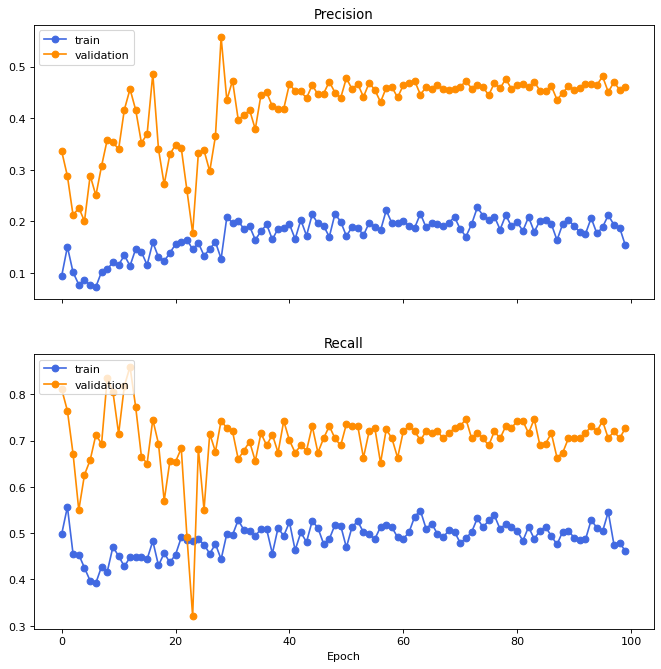

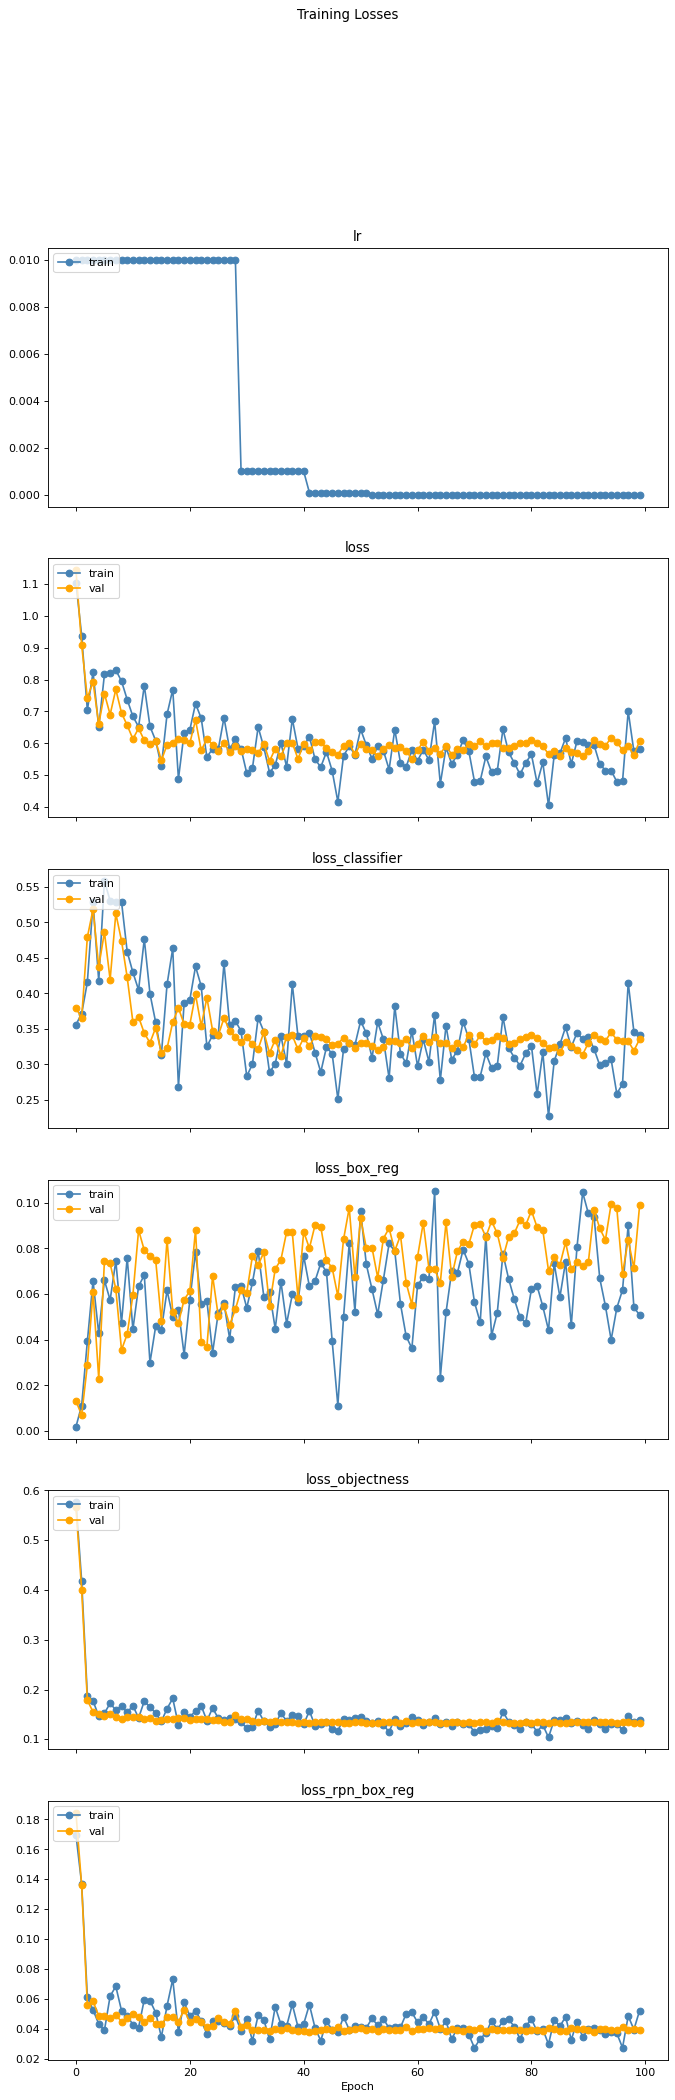

====================| Epoch [100] Done | It has took [163.65] min, Avg time: [98.19] sec/epoch | Estimate time for [100] epochs: [163.65] min | Epoch took [93] sec |====================
====================| Training Done, start testing! | [100] Epochs Training time: [9819] seconds, Avg time / Epoch: [98.19] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_7430_ap_0_5567_test_ar_0_7974_ap_0_5392_epoch29_WithClincal_05-02-2022 17-07-17_with_clinical]====================
====================Best AR validation model has been saved to: [val_ar_0_8595_ap_0_4564_test_ar_0_7599_ap_0_4436_epoch13_WithClincal_05-02-2022 16-41-36_with_clinical]====================
Evaluation:  [ 0/15]  eta: 0:00:12  loss: 0.4473 (0.4473)  loss_classifier: 0.3078 (0.3078)  loss_box_reg: 0.0008 (0.0008)  loss_objectness: 0.0972 (0.0972)  loss_rpn_box_reg: 0.0415 (0.0415)  model_time: 0.0497 (0.0497)  evaluator_time: 0.0010 (0.0010)  time: 0.8218  data: 0.7104  m

In [9]:
for model_setup in all_model_setups:

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(model_setup)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": model_setup.use_mask,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
    )

    train_coco, val_coco, test_coco = get_cocos(
        train_dataloader, val_dataloader, test_dataloader
    )


    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )

    print_params_setup(model)

    model.to(device)

    iou_types = get_iou_types(model, model_setup)
    optimizer = get_optimiser(model, model_setup)
    lr_scheduler = get_lr_scheduler(optimizer, model_setup)

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Tooke [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_ap_ar = None

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_data.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ### update the learning rate
        if train_info.epoch> model_setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(val_ap_ar["ap"] if not val_ap_ar is None else 0)
                else:
                    lr_scheduler.step()

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = xami_evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_data.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_train_val_ap_ars(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_f.print_title(
            f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
        )

        #######################################################################################
        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )

    val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

    train_info = end_train(
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ar,
        last_val_ap=val_ap,
        test_dataloader=test_dataloader,
        device=device,   
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
    )

    train_infos.append(train_info)


In [10]:
# [model]: 4,969,055
# [model.backbone]: 1,009,968
# [model.rpn]: 3,595
# [model.roi_heads]: 3,955,492
# [model.roi_heads.mask_head]: 1,807,360
# [model.roi_heads.box_head]: 1,853,440
# [model.roi_heads.box_head.fc6]: 803,840
# [model.roi_heads.box_head.fc7]: 1,049,600
# [model.roi_heads.box_predictor]: 30,750


In [11]:
# resnet18 -

# mobilenet - 37,301,135
# resnet18 - 30,918,643


In [12]:
val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

train_info = end_train(
    train_info=train_info,
    model=model,
    optim=optimizer,
    eval_params_dict=eval_params_dict,
    last_val_ar=val_ar,
    last_val_ap=val_ap,
    test_dataloader=test_dataloader,
    device=device,   
    test_coco=test_coco,
    iou_types=iou_types,
    score_thres=None,
)

print(train_info)

====================| Training Done, start testing! | [100] Epochs Training time: [9830] seconds, Avg time / Epoch: [98.3] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_7430_ap_0_5567_test_ar_0_7974_ap_0_5392_epoch29_WithClincal_05-02-2022 17-07-17_with_clinical]====================
====================Best AR validation model has been saved to: [val_ar_0_8595_ap_0_4564_test_ar_0_7599_ap_0_4436_epoch13_WithClincal_05-02-2022 16-41-36_with_clinical]====================
Evaluation:  [ 0/15]  eta: 0:00:11  loss: 0.8662 (0.8662)  loss_classifier: 0.5713 (0.5713)  loss_box_reg: 0.1541 (0.1541)  loss_objectness: 0.1267 (0.1267)  loss_rpn_box_reg: 0.0141 (0.0141)  model_time: 0.0827 (0.0827)  evaluator_time: 0.0020 (0.0020)  time: 0.7585  data: 0.5601  max mem: 703
Evaluation:  [14/15]  eta: 0:00:00  loss: 0.5710 (0.5731)  loss_classifier: 0.3148 (0.3442)  loss_box_reg: 0.0536 (0.0550)  loss_objectness: 0.1279 (0.1356)  loss_rpn_box_reg:

========================================For Training [with_clinical]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='mobilenet_v3', optimiser='sgd', lr=0.01, weight_decay=0.001, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=10, multiStepLR_milestones=[30, 50, 70, 90], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=False, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=32, clinical_num_len=9, clinical_conv_channels=32, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, fuse_depth=4)

Best AP validation model has

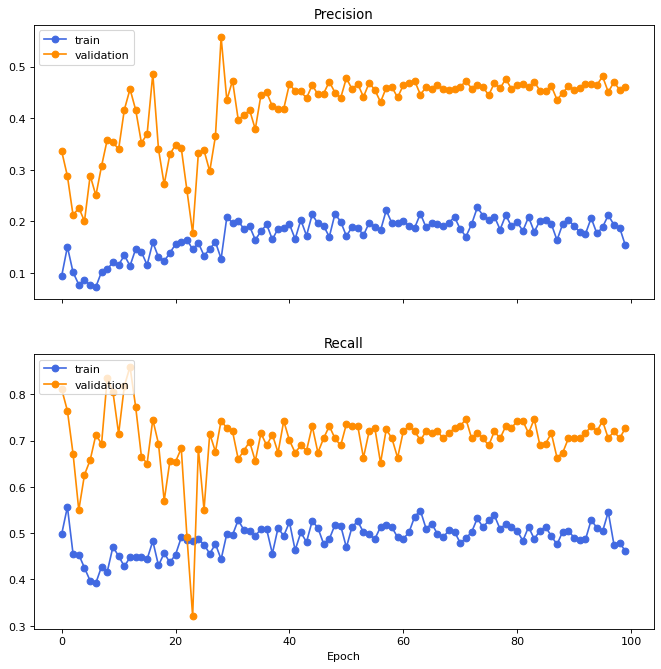

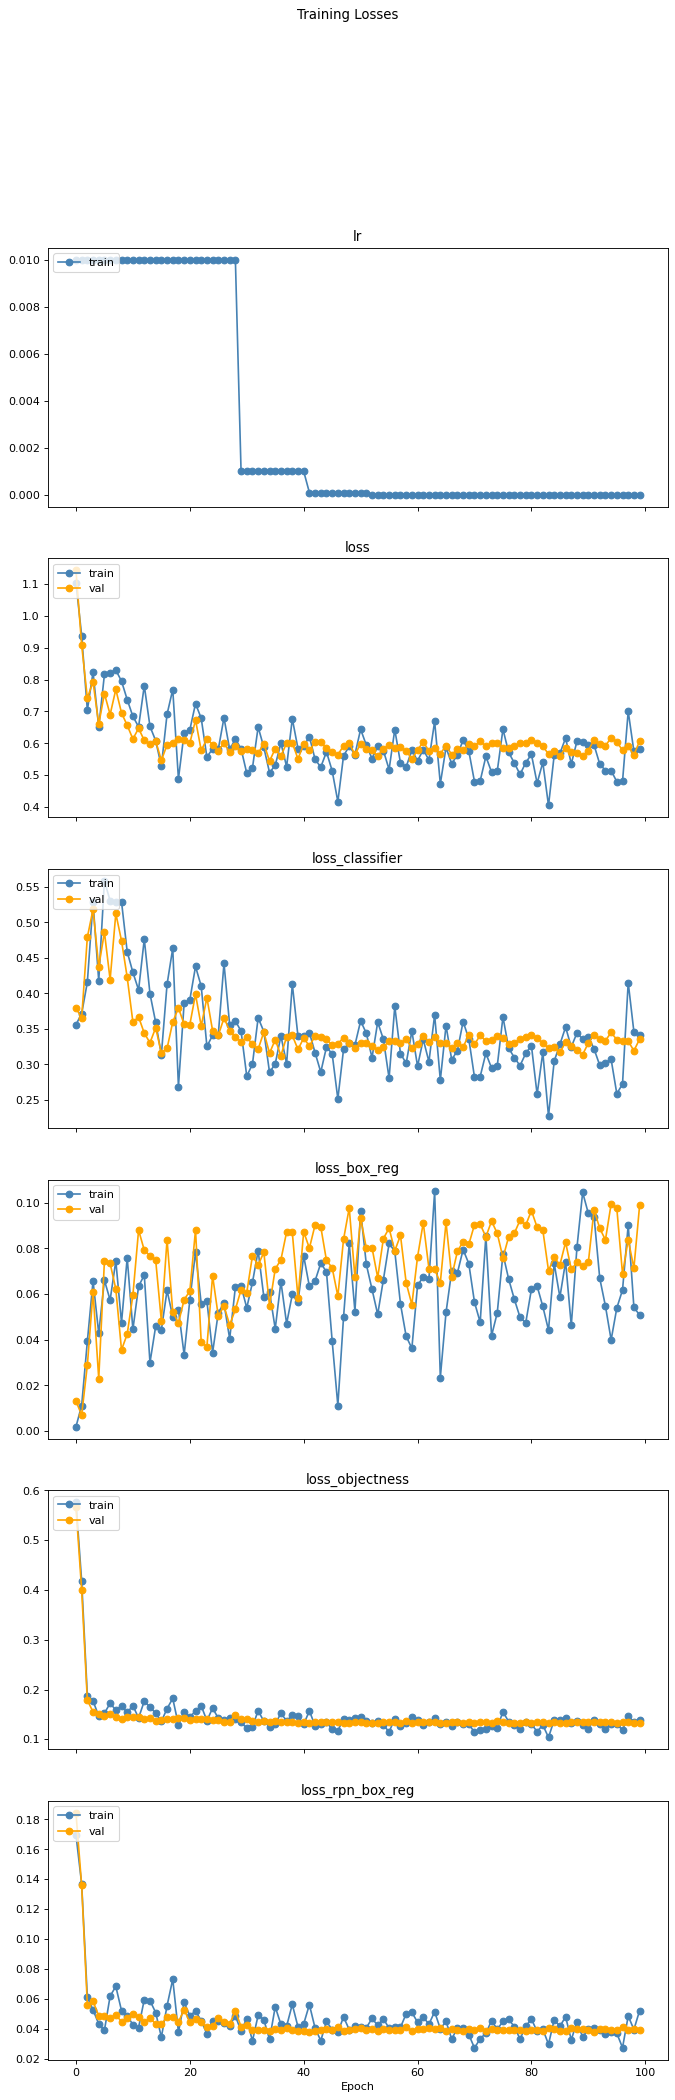

In [13]:
for train_info in train_infos:
    print(train_info)
    model_setup = train_info.model_setup
    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    print_params_setup(model)
    plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
    plot_losses(train_info.train_data, train_info.val_data)



In [14]:
# for train_info in train_infos:
#     print(train_info)


In [15]:
# train_info.model_setup


In [16]:
# ========================================For Training [custom_without_clinical_swim]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=0.05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ===========================================================================================================================

# Best AP validation model has been saved to: [val_ar_0_5307_ap_0_2054_test_ar_0_5321_ap_0_1726_epoch87_WithoutClincal_04-17-2022 06-51-10_custom_without_clinical_swim]
# Best AR validation model has been saved to: [val_ar_0_5313_ap_0_1540_test_ar_0_5906_ap_0_1486_epoch59_WithoutClincal_04-17-2022 05-48-30_custom_without_clinical_swim]
# The final model has been saved to: [val_ar_0_2175_ap_0_1390_test_ar_0_2231_ap_0_0901_epoch200_WithoutClincal_04-17-2022 10-49-59_custom_without_clinical_swim]

# ===========================================================================================================================
# ========================================For Training [custom_with_clinical_swim]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=0.05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================================================================================================

# Best AP validation model has been saved to: [val_ar_0_5081_ap_0_2210_test_ar_0_5392_ap_0_1725_epoch95_WithClincal_04-17-2022 15-26-02_custom_with_clinical_swim]
# Best AR validation model has been saved to: [val_ar_0_5377_ap_0_1821_test_ar_0_4561_ap_0_1193_epoch67_WithClincal_04-17-2022 14-02-28_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_2752_ap_0_1293_test_ar_0_3391_ap_0_1097_epoch200_WithClincal_04-17-2022 20-31-24_custom_with_clinical_swim]

# ========================================================================================================================


In [17]:
# ResNet Result for 100 epochs.
# ========================================For Training [custom_without_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-13_custom_without_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_4523_ap_0_2372_test_ar_0_5141_ap_0_2213_epoch100_WithoutClincal_04-12-2022 09-53-17_custom_without_clinical_no_pretrained]
# ========================================For Training [custom_with_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5056_ap_0_2360_test_ar_0_5891_ap_0_2176_epoch90_WithClincal_04-12-2022 18-38-40_custom_with_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4589_ap_0_2492_test_ar_0_5737_ap_0_2272_epoch78_WithClincal_04-12-2022 17-26-34_custom_with_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_3470_ap_0_1944_test_ar_0_4186_ap_0_2042_epoch100_WithClincal_04-12-2022 19-38-09_custom_with_clinical_no_pretrained]


In [18]:
# Swin result. (of of them is broken.)
# ========================================For Training [custom_without_clinical_swim]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5338_ap_0_1657_test_ar_0_5228_ap_0_1454_epoch49_WithoutClincal_04-15-2022 10-08-43_custom_without_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_4055_ap_0_2096_test_ar_0_4849_ap_0_1451_epoch94_WithoutClincal_04-15-2022 14-48-57_custom_without_clinical_swim]
# The final model has been saved to: [val_ar_0_2245_ap_0_1203_test_ar_0_2234_ap_0_0908_epoch200_WithoutClincal_04-16-2022 00-44-53_custom_without_clinical_swim]
# ========================================For Training [custom_with_clinical_swim]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5038_ap_0_1500_test_ar_0_5308_ap_0_1325_epoch75_WithClincal_04-16-2022 09-55-55_custom_with_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_4485_ap_0_2138_test_ar_0_5002_ap_0_1346_epoch84_WithClincal_04-16-2022 11-10-33_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_0727_ap_0_0008_test_ar_0_1429_ap_0_0030_epoch183_WithClincal_04-17-2022 03-16-37_custom_with_clinical_swim]


In [19]:
# for idx, train_info in enumerate(train_infos):
#     plot_train_val_evaluators(
#         train_info.train_evaluators,
#         train_info.val_evaluators,
#         areaRng="all",
#         iouThr=0.5,
#         maxDets=10,
#     )

# # [Findings]:
# # 1. The model without clinical data seems converge faster.


In [20]:
# for train_info in train_infos:
#     print("="*40 + f"For Training [{train_info.model_setup.name}]" + "="*40)
#     print(train_info.model_setup)
#     print("="*40)
#     print(f"Best AR validation model has been saved to: [{train_info.best_ar_val_model_path}]")
#     print(f"Best AP validation model has been saved to: [{train_info.best_ap_val_model_path}]")
#     print(f"The final model has been saved to: [{train_info.final_model_path}]")


In [21]:
# ========================================For Training [custom_without_clinical_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5181_ap_0_2127_test_ar_0_5659_ap_0_2037_epoch36_WithoutClincal_04-10-2022 08-07-20_custom_without_clinical_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4635_ap_0_2291_test_ar_0_5178_ap_0_1937_epoch17_WithoutClincal_04-10-2022 07-30-34_custom_without_clinical_pretrained]
# The final model has been saved to: [val_ar_0_4279_ap_0_2052_test_ar_0_4103_ap_0_1757_epoch50_WithoutClincal_04-10-2022 08-34-20_custom_without_clinical_pretrained]
# ========================================For Training [custom_with_clinical_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5171_ap_0_2336_test_ar_0_5267_ap_0_1545_epoch39_WithClincal_04-10-2022 10-15-22_custom_with_clinical_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4581_ap_0_2496_test_ar_0_5533_ap_0_1655_epoch49_WithClincal_04-10-2022 10-38-54_custom_with_clinical_pretrained]
# The final model has been saved to: [val_ar_0_3912_ap_0_1756_test_ar_0_5129_ap_0_1736_epoch50_WithClincal_04-10-2022 10-41-48_custom_with_clinical_pretrained]
# ========================================For Training [custom_without_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4295_ap_0_1586_test_ar_0_4991_ap_0_2054_epoch39_WithoutClincal_04-10-2022 12-02-33_custom_without_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4156_ap_0_1726_test_ar_0_5085_ap_0_1841_epoch40_WithoutClincal_04-10-2022 12-05-11_custom_without_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_2427_ap_0_1189_test_ar_0_3630_ap_0_1724_epoch50_WithoutClincal_04-10-2022 12-25-02_custom_without_clinical_no_pretrained]
# ========================================For Training [custom_with_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4338_ap_0_2249_test_ar_0_4445_ap_0_1816_epoch49_WithClincal_04-10-2022 14-24-02_custom_with_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4338_ap_0_2249_test_ar_0_4445_ap_0_1816_epoch49_WithClincal_04-10-2022 14-24-04_custom_with_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_3519_ap_0_1750_test_ar_0_4113_ap_0_1602_epoch50_WithClincal_04-10-2022 14-27-02_custom_with_clinical_no_pretrained]
# ========================================For Training [custom_without_clinical_swim]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4324_ap_0_1400_test_ar_0_4371_ap_0_1408_epoch45_WithoutClincal_04-10-2022 16-09-22_custom_with_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_3653_ap_0_1552_test_ar_0_3867_ap_0_1298_epoch29_WithoutClincal_04-10-2022 15-34-21_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_3816_ap_0_1417_test_ar_0_3788_ap_0_1313_epoch50_WithoutClincal_04-10-2022 16-20-24_custom_with_clinical_swim]
# ========================================For Training [custom_with_clinical_swim]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_swim', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin', optimiser='adamw', lr=0.0001, weight_decay=5e-05, pretrained=False, record_training_performance=False, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4182_ap_0_1406_test_ar_0_4256_ap_0_0967_epoch44_WithClincal_04-10-2022 18-17-49_custom_with_clinical_swim]
# Best AP validation model has been saved to: [val_ar_0_3589_ap_0_1554_test_ar_0_4126_ap_0_1312_epoch41_WithClincal_04-10-2022 18-09-37_custom_with_clinical_swim]
# The final model has been saved to: [val_ar_0_3008_ap_0_0923_test_ar_0_3878_ap_0_1092_epoch50_WithClincal_04-10-2022 18-33-30_custom_with_clinical_swim]


In [22]:
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5702_ap_0_1778_test_ar_0_5586_ap_0_1920_epoch125_WithClincal_04-07-2022 16-10-43_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_5088_ap_0_2175_test_ar_0_5247_ap_0_1571_epoch85_WithClincal_04-07-2022 11-57-59_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3453_ap_0_1556_test_ar_0_3459_ap_0_1416_epoch300_WithClincal_04-08-2022 09-41-51_custom_with_clinical]


In [23]:
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='swin')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5112_ap_0_2027_test_ar_0_4902_ap_0_1178_epoch86_WithClincal_04-07-2022 12-05-12_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_5088_ap_0_2175_test_ar_0_5247_ap_0_1571_epoch85_WithClincal_04-07-2022 11-57-59_custom_with_clinical]
# The final model has been saved to: [val_ar_0_2673_ap_0_1166_test_ar_0_3118_ap_0_1119_epoch100_WithClincal_04-07-2022 13-31-10_custom_with_clinical]


## Model Paths


In [24]:
### Full training

# ========================================For Training [original]========================================
# ModelSetup(use_clinical=False, use_custom_model=False, use_early_stop_model=True, name='original', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5230_ap_0_2576_test_ar_0_5678_ap_0_2546_epoch28_WithoutClincal_03-28-2022 06-56-13_original] *
# Best AP validation model has been saved to: [val_ar_0_4828_ap_0_2977_test_ar_0_5052_ap_0_2331_epoch20_WithoutClincal_03-28-2022 06-34-49_original]
# The final model has been saved to: [val_ar_0_4463_ap_0_2006_test_ar_0_4904_ap_0_2154_epoch50_WithoutClincal_03-28-2022 07-51-38_original]


# ========================================For Training [custom_without_clinical]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4941_ap_0_2401_test_ar_0_5191_ap_0_2368_epoch11_WithoutClincal_03-28-2022 08-19-58_custom_without_clinical]
# Best AP validation model has been saved to: [val_ar_0_4575_ap_0_2689_test_ar_0_4953_ap_0_2561_epoch40_WithoutClincal_03-28-2022 09-15-40_custom_without_clinical] *
# The final model has been saved to: [val_ar_0_3348_ap_0_2367_test_ar_0_3721_ap_0_1814_epoch50_WithoutClincal_03-28-2022 09-34-36_custom_without_clinical]

### Dropout = (0.0)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5363_ap_0_2963_test_ar_0_5893_ap_0_2305_epoch36_WithClincal_03-28-2022 20-06-43_custom_with_clinical]*
# Best AP validation model has been saved to: [val_ar_0_5363_ap_0_2963_test_ar_0_5893_ap_0_2305_epoch36_WithClincal_03-28-2022 20-06-44_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3798_ap_0_2078_test_ar_0_5041_ap_0_2052_epoch50_WithClincal_03-28-2022 20-36-05_custom_with_clinical]


### Dropout = (0.2)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5126_ap_0_2498_test_ar_0_5607_ap_0_2538_epoch18_WithClincal_03-28-2022 10-18-55_custom_with_clinical]*
# Best AP validation model has been saved to: [val_ar_0_5090_ap_0_2753_test_ar_0_5324_ap_0_2337_epoch32_WithClincal_03-28-2022 10-47-07_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3097_ap_0_2025_test_ar_0_3521_ap_0_1591_epoch50_WithClincal_03-28-2022 11-22-58_custom_with_clinical]

### Dropout = (0.3)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5512_ap_0_2769_test_ar_0_4896_ap_0_1875_epoch48_WithClincal_03-28-2022 16-01-09_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_4631_ap_0_2860_test_ar_0_4462_ap_0_2249_epoch46_WithClincal_03-28-2022 15-56-11_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3993_ap_0_2326_test_ar_0_4957_ap_0_2390_epoch50_WithClincal_03-28-2022 16-06-00_custom_with_clinical]*


### Dropout = (0.5)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5887_ap_0_2834_test_ar_0_5532_ap_0_1683_epoch34_WithClincal_03-28-2022 17-38-54_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_4955_ap_0_2942_test_ar_0_5449_ap_0_2566_epoch28_WithClincal_03-28-2022 17-25-34_custom_with_clinical]*
# The final model has been saved to: [val_ar_0_4053_ap_0_2322_test_ar_0_4286_ap_0_2031_epoch50_WithClincal_03-28-2022 18-12-35_custom_with_clinical]


# We need a enum function to load the model.


In [25]:
# 50 epoch
# val_ar_0_2370_ap_0_1530_test_ar_0_2396_ap_0_1236_epoch50_WithoutClincal_03-27-2022 02-41-12 (original)
# val_ar_0_2658_ap_0_1993_test_ar_0_2717_ap_0_1816_epoch50_WithoutClincal_03-27-2022 04-56-32(custom without clinical)
# val_ar_0_3839_ap_0_2107_test_ar_0_5359_ap_0_2286_epoch50_WithClincal_03-27-2022 06-59-57 (custom with clinical)

# Single 100 epoch
# val_ar_0_4986_ap_0_2911_test_ar_0_5360_ap_0_2273_epoch35_WithClincal_03-27-2022 16-00-27 (best)
# val_ar_0_1551_ap_0_1462_test_ar_0_2225_ap_0_1449_epoch100_WithClincal_03-27-2022 18-23-42(final)
